In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

### 读取文件并合并

In [2]:
city_list = '北京,上海,广州,深圳'.split(',')

In [3]:
path_list = [f'./{i}历史天气.xlsx' for i in city_list]
df_list = []
for path in path_list :
    df = pd.read_excel(path)
    df['地区']= path[2:4]
    df_list.append(df)

In [4]:
df_p = pd.concat(df_list)
df_p

,日期,最高温,最低温,天气,风力风向,空气质量指数,地区
0,2021-05-01 周六,20°,7°,晴,北风3级,33 优,北京
1,2021-05-02 周日,21°,13°,阴~晴,南风3级,39 优,北京
2,2021-05-03 周一,24°,13°,晴~多云,西南风微风,63 良,北京
3,2021-05-04 周二,23°,10°,多云,西北风3级,53 良,北京
4,2021-05-05 周三,27°,16°,晴,西南风微风,70 良,北京
...,...,...,...,...,...,...,...
525,2019-12-10 周二,22°,12°,晴,东北风2级,65 良,深圳
526,2019-12-11 周三,23°,16°,晴,东北风2级,72 良,深圳
527,2019-12-12 周四,24°,16°,晴~多云,东南风2级,59 良,深圳
528,2019-12-13 周五,24°,15°,晴,东南风2级,60 良,深圳


In [5]:
#df['空气质量等级'] = df['空气质量指数'].map(lambda i: i[-1:])


### 数据清洗

In [6]:
df_p['空气质量等级'] = df_p['空气质量指数'].map(lambda i: re.compile(r'\s(\w{1,15})').findall(i)[0])
df_p['空气质量指数'] = df_p['空气质量指数'].map(lambda i: re.compile(r'(\d*)\s').findall(i)[0]).astype('int32')

In [7]:
df_p.head()

,日期,最高温,最低温,天气,风力风向,空气质量指数,地区,空气质量等级
0,2021-05-01 周六,20°,7°,晴,北风3级,33,北京,优
1,2021-05-02 周日,21°,13°,阴~晴,南风3级,39,北京,优
2,2021-05-03 周一,24°,13°,晴~多云,西南风微风,63,北京,良
3,2021-05-04 周二,23°,10°,多云,西北风3级,53,北京,良
4,2021-05-05 周三,27°,16°,晴,西南风微风,70,北京,良


In [8]:
df_p.loc[:,'日期'] = df_p['日期'].str[0:10]
df_p['风向'] = df_p['风力风向'].map(lambda i: i[:-2])
df_p.loc[:,'风力等级'] = df_p['风力风向'].map(lambda i: i[-2])
df_p.loc[:,'风力等级'] = df_p.loc[:,'风力等级'].map(lambda i: 0 if i == '微' else i).astype('int8')
df_p.loc[:,'最高温'] = df_p['最高温'].str.replace('°','').astype('int32')
df_p.loc[:,'最低温'] = df_p['最低温'].str.replace('°','').astype('int32')
del df_p['风力风向']

df_p.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
0,2021-05-01,20,7,晴,33,北京,优,北风,3
1,2021-05-02,21,13,阴~晴,39,北京,优,南风,3
2,2021-05-03,24,13,晴~多云,63,北京,良,西南风,0
3,2021-05-04,23,10,多云,53,北京,良,西北风,3
4,2021-05-05,27,16,晴,70,北京,良,西南风,0


In [9]:
df_p['日期'] = pd.to_datetime(df_p['日期'])
df_p.set_index('日期',drop = False,inplace = True)
df_p.sort_index(inplace = True )

### 初步清洗完成，得到需要的数据，填补缺失值

In [10]:
df = df_p.loc['2020-01-01':'2020-12-31']
df

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1
...,...,...,...,...,...,...,...,...,...
2020-12-30,2020-12-30,15,5,晴,61,深圳,良,东北风,5
2020-12-31,2020-12-31,13,3,晴,37,广州,优,东北风,4
2020-12-31,2020-12-31,13,5,多云~晴,44,深圳,优,东北风,4


In [11]:
pd.unique(df['空气质量等级'])

array(['良', '优', '轻度', '中度', '重度'], dtype=object)

In [12]:
def air_s(i):
    if i in ['中度', '轻度', '重度', '严重']:
        return f'{i}污染'
    else:
        return i
df.loc[:,'空气质量等级'] = df['空气质量等级'].copy().map(air_s).copy()

C:\Users\Thinkpad\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
pd.unique(df['空气质量等级'])

array(['良', '优', '轻度污染', '中度污染', '重度污染'], dtype=object)

### 对四个城市每月平均温度变化进行分析

In [14]:
df.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1


In [15]:
month_t = df.groupby([df.index.month,'地区'])['最高温'].mean().unstack()
month_t.head()

地区,上海,北京,广州,深圳
日期,,,,
1,9.290323,3.935484,21.129032,21.516129
2,12.689655,5.586207,20.862069,21.724138
3,15.967742,15.000000,22.774194,23.967742
4,20.200000,21.366667,24.666667,25.233333
5,26.419355,25.967742,31.064516,30.322581


In [16]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

Text(0, 0.5, '温度℃')

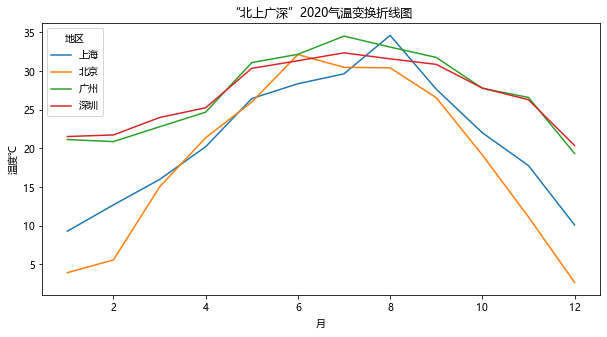

In [42]:
month_t.plot(figsize=(10, 5))
plt.title('“北上广深”2020气温变换折线图')
plt.xlabel('月')
plt.ylabel('温度℃')

### 分析四个城市一年中，每天的温度分情况

In [18]:
df.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1


In [19]:
df_plot =  df[['最高温','地区']].set_index('地区',append = True).unstack().reset_index(drop = True)
df_plot.head()

最高温           
地区  上海 北京  广州  深圳
0    9  0  20  18
1   12  4  22  19
2   11  7  25  24
3   10  9  26  25
4   13  2  24  24

In [20]:
columns_plot_p = df_plot.columns.values.tolist()
columns_plot =[]
for i in columns_plot_p:
    a,b = i
    columns_plot.append(b)

In [21]:
data_p = list(df_plot.to_dict().values())
all_data = []
for i in data_p:
    values = list(i.values())
    all_data.append(values)

 Text(1, 0, '上海'),
 Text(2, 0, '北京'),
 Text(3, 0, '广州'),
 Text(4, 0, '深圳'),
 Text(1, 0, '上海'),
 Text(2, 0, '北京'),
 Text(3, 0, '广州'),
 Text(4, 0, '深圳')]

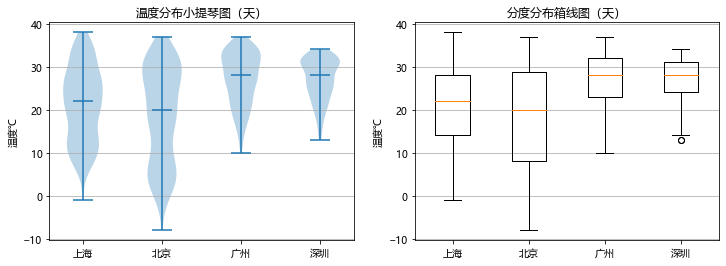

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].violinplot(all_data,showmeans=False,showmedians=True)
axs[0].set_title('温度分布小提琴图（天）')
axs[1].boxplot(all_data)
axs[1].set_title('分度分布箱线图（天）')
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))])
    ax.set_ylabel('温度℃')
plt.setp(axs, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels= columns_plot)

### 分析四个城市一年中空气质量的分布情况

In [23]:
df.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1


In [24]:
month_a = df.groupby(['地区','空气质量等级'])['空气质量等级'].count()
month_a = month_a.unstack(fill_value = 0,level = 0)
month_a.head()

地区,上海,北京,广州,深圳
空气质量等级,,,,
中度污染,5,10,1,0
优,222,144,237,292
良,121,167,116,74
轻度污染,18,39,12,0
重度污染,0,6,0,0


In [25]:
from pandas.api.types import CategoricalDtype
act_size_order = CategoricalDtype(['优','良','轻度污染','中度污染','重度污染'],ordered = True)
month_a = month_a.reset_index()
month_a['空气质量等级'] = month_a['空气质量等级'].astype(act_size_order)
month_a = month_a.sort_values('空气质量等级').set_index('空气质量等级')
month_a

地区,上海,北京,广州,深圳
空气质量等级,,,,
优,222,144,237,292
良,121,167,116,74
轻度污染,18,39,12,0
中度污染,5,10,1,0
重度污染,0,6,0,0


In [26]:
dic_keys = month_a.index.values
columns_names = month_a.columns.values.tolist()

In [27]:
month_b = month_a.stack().to_dict().values()
values = np.array(list(month_b)).reshape(5,4).tolist()
values

[[222, 144, 237, 292],
 [121, 167, 116, 74],
 [18, 39, 12, 0],
 [5, 10, 1, 0],
 [0, 6, 0, 0]]

In [28]:
month_c = df.groupby(['地区','空气质量等级'])['空气质量等级'].count()
month_c = month_c.unstack(fill_value = 0)
month_c = month_c[['优','良','轻度污染','中度污染','重度污染']]

Text(0.5, 0, '')

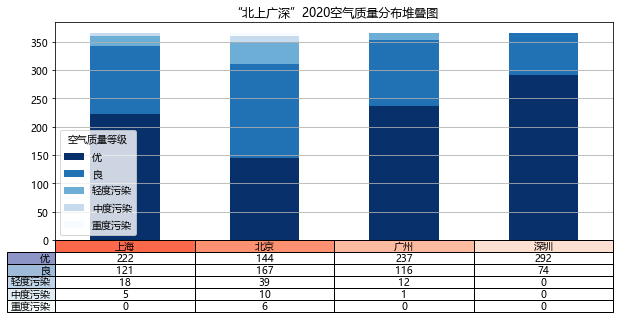

In [29]:
month_c.plot(kind='bar',grid = True,colormap='Blues_r',stacked=True,figsize=(10,4),title = '“北上广深”2020空气质量分布堆叠图')
plt.table(cellText =values,
          cellLoc='center',
          cellColours = None,
          rowLabels = dic_keys,
          rowColours = plt.cm.BuPu(np.linspace(0, 0.5,5))[::-1],  # BuPu可替换成其他colormap
          colLabels = columns_names,
          colColours = plt.cm.Reds(np.linspace(0, 0.5,5))[::-1], 
          rowLoc='right',
          loc='bottom')
plt.xticks([])
plt.xlabel('')

### 分析污染天气在季节上的分布规律

In [30]:
df.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1


In [31]:
df_p = df[['空气质量等级','地区']].copy()
df_p['count'] = 1

In [32]:
df_p=df_p.groupby(by = [df_p.index.quarter,'地区','空气质量等级'])['count'].count()
df_p.head()

日期  地区  空气质量等级
1   上海  中度污染       3
        优         51
        良         32
        轻度污染       5
    北京  中度污染       5
Name: count, dtype: int64

In [33]:
df_u = df_p.unstack(fill_value=0,level = -1)
df_u = df_u.reset_index()
df_u = df_u[['日期','地区','轻度污染','中度污染','重度污染']]
df_u['污染天数'] =  df_u['轻度污染'] + df_u['中度污染'] + df_u['重度污染']
df_u = df_u[['日期','地区','污染天数']]
df_u.head()

空气质量等级,日期,地区,污染天数
0,1,上海,8
1,1,北京,18
2,1,广州,1
3,1,深圳,0
4,2,上海,7


In [34]:
df_u = df_u.set_index(['日期','地区']).unstack().reset_index().set_index('日期')
df_u

空气质量等级 污染天数           
地区       上海  北京  广州 深圳
日期                    
1         8  18   1  0
2         7  16  11  0
3         0   5   0  0
4         8  16   1  0

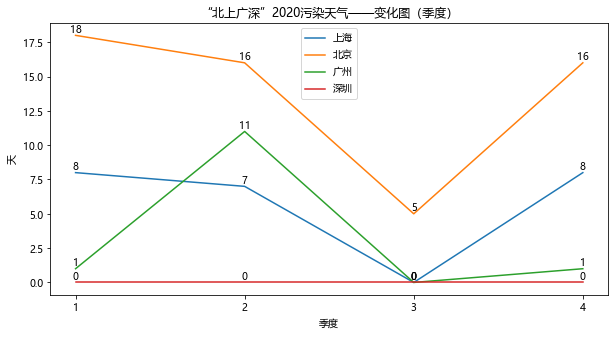

In [35]:
plt.figure(figsize = (10,5))
plt.plot(df_u[('污染天数','上海')],label='上海')
plt.plot(df_u[('污染天数','北京')],label='北京')
plt.plot(df_u[('污染天数','广州')],label='广州')
plt.plot(df_u[('污染天数','深圳')],label='深圳')
plt.title('“北上广深”2020污染天气——变化图（季度）')
plt.xticks(range(1,5))
plt.xlabel('季度')
plt.ylabel('天')
plt.legend()
for a,b in zip(range(1,5),list(df_u[('污染天数','上海')])):
    plt.text(a,b,b, ha='center', va='bottom', fontsize=10)
for a,b in zip(range(1,5),list(df_u[('污染天数','北京')])):
    plt.text(a,b,b, ha='center', va='bottom', fontsize=10)
for a,b in zip(range(1,5),list(df_u[('污染天数','广州')])):
    plt.text(a,b,b, ha='center', va='bottom', fontsize=10)
for a,b in zip(range(1,5),list(df_u[('污染天数','深圳')])):
    plt.text(a,b,b, ha='center', va='bottom', fontsize=10)

### 探寻“空气质量”的影响因素

In [36]:
df.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级
日期,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1


In [37]:
df_p = df.copy()
df_p.loc[:,'温差'] = df_p['最高温']-df_p['最低温']
df_p.head()

,日期,最高温,最低温,天气,空气质量指数,地区,空气质量等级,风向,风力等级,温差
日期,,,,,,,,,,
2020-01-01,2020-01-01,0,-9,晴,53,北京,良,东北风,1,9
2020-01-01,2020-01-01,18,16,阴~多云,52,深圳,良,东南风,2,2
2020-01-01,2020-01-01,9,7,晴~小雨,27,上海,优,东南风,2,2
2020-01-01,2020-01-01,20,13,多云~晴,60,广州,良,东北风,2,7
2020-01-02,2020-01-02,19,16,阴~多云,50,深圳,优,东南风,1,3


In [38]:
df_p.corr().loc['空气质量指数',:]

最高温      -0.163287
最低温      -0.256182
空气质量指数    1.000000
风力等级     -0.332844
温差        0.287805
Name: 空气质量指数, dtype: float64

#### 空气质量影响因素分析结果
* 空气质量指数和风力等级相关性最强，为负相关，即风力越大，空气质量指数越低，空气质量越好
* 空气质量与温差和最低温相的关性也较强，温差越大时，空气质量可能越差，最低温越低时，空气质量可能越差

### 对北京差天气的原因分析

In [39]:
df_p.groupby(by = '地区')['风力等级'].mean()

地区
上海    2.524590
北京    2.038251
广州    2.565574
深圳    2.565574
Name: 风力等级, dtype: float64

In [40]:
df_p.groupby(by = '地区')['最低温'].mean()

地区
上海    15.426230
北京     8.262295
广州    20.366120
深圳    21.385246
Name: 最低温, dtype: float64

In [41]:
df_p.groupby(by = '地区')['温差'].mean()

地区
上海     5.811475
北京    10.453552
广州     6.778689
深圳     5.557377
Name: 温差, dtype: float64

### 北京空气质量较差的原因分析结果：
* 虽然和空气质量相关性最高的是风力等级，但不是造成北京空气质量较差的主要原因
* 北京的空气质量较差是因为北京的最低温度和温差比上海、广州、深圳都要大很多

##### 以上结论忽视其他因素影响，仅是在收集数据范围内分析得到的结果

In [ ]:
df.corr()
df.describe()
df.cov()